In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install xgboost==1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


In [ ]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 11.4 MB/s eta 0:00:00


In [ ]:
import os
# import torch
import sys
import sktime
import tqdm as tq
import xgboost as xgb

import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [ ]:
print("xgboost version: {}".format(xgb.__version__)) ## 1.2.1

In [ ]:
# 전처리 한 파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/processing/train_preprocessed_incsolar_month.csv')
train.head()

,num,date_time,power,prec,wind,hum,temp,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag
0,1,2022-06-01 00:00:00,1085.28,0.0,0.9,42.0,18.6,2,6,22,1774.744615,1706.318118,446.882767,1,0.000000,1.000000,49.6576,-5.4,0
1,1,2022-06-01 01:00:00,1047.36,0.0,1.1,45.0,18.0,2,6,22,1687.347692,1622.620235,439.662704,1,0.258819,0.965926,47.7625,-11.4,0
2,1,2022-06-01 02:00:00,974.88,0.0,1.5,45.0,17.7,2,6,22,1571.483077,1506.971294,412.071906,1,0.500000,0.866025,47.2225,-17.7,0
3,1,2022-06-01 03:00:00,953.76,0.0,1.4,48.0,16.7,2,6,22,1522.153846,1437.365647,391.205981,1,0.707107,0.707107,44.7856,-25.0,0
4,1,2022-06-01 04:00:00,986.40,0.0,2.8,43.0,18.4,2,6,22,1506.793846,1447.321412,381.099697,1,0.866025,0.500000,49.0061,-30.6,0


## model tuning

In [ ]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

eta(learning rate) : 0.01 로 했을 때보다 0.05로 했을 때 결과가 좋게 나옴  
최적의 eta 값을 찾기 위해 바꿔가며 학습

In [ ]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import make_scorer
smape = make_scorer(SMAPE, greater_is_better = False)

df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
# df = pd.read_csv('./data/xgboost/hyperparameter_xgb_solar.csv')

grid = {'n_estimators' : [200], 'eta' : [0.05], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1, 0.1),  'subsample' :np.arange(0.8, 1, 0.1)}

# 건물 번호별로 GridSearch로 parameter 생성
for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i, ].iloc[:, 3:]
    # 마지막 일주일 발전량을 validset으로 24시간*7일 = 168
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)


    pds = PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed = 10, gpu_id = 0,
                                                tree_method = 'gpu_hist', predictor= 'gpu_predictor', eval_metric = 'mae'),
                       param_grid = grid, scoring = smape, cv = pds, refit = True, verbose = True)


    gcv.fit(x, y)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_test)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_test, pred)))
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/xgboost/hyperparameter_xgb_solar0821_07.csv', index = False)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Fitting 1 folds for each of 168 candidates, totalling 168 fits
{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building1|| SMAPE : 0.7403217606842651


  1%|          | 1/100 [00:50<1:22:32, 50.03s/it]/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Fitting 1 folds for each of 168 candidates, totalling 168 fits


  2%|▏         | 2/100 [01:29<1:11:15, 43.63s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building2|| SMAPE : 1.5696827409694754
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  3%|▎         | 3/100 [02:11<1:09:12, 42.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building3|| SMAPE : 0.8494797375738004
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  4%|▍         | 4/100 [02:47<1:04:46, 40.48s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building4|| SMAPE : 0.3866939274755372
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  5%|▌         | 5/100 [03:25<1:02:34, 39.52s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building5|| SMAPE : 2.0322638518606357
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  6%|▌         | 6/100 [04:04<1:01:23, 39.19s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building6|| SMAPE : 1.2972103789562346
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  7%|▋         | 7/100 [04:44<1:01:10, 39.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building7|| SMAPE : 0.8577593501796054
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  8%|▊         | 8/100 [05:19<58:14, 37.99s/it]  

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 1.1066543629760497
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  9%|▉         | 9/100 [05:57<57:42, 38.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building9|| SMAPE : 1.0277517314132056
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 10%|█         | 10/100 [06:34<56:38, 37.76s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building10|| SMAPE : 0.43251906416180086
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 11%|█         | 11/100 [07:07<53:57, 36.38s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building11|| SMAPE : 1.2499640749123417
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 12%|█▏        | 12/100 [07:46<54:22, 37.07s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building12|| SMAPE : 1.6102521764073834
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 13%|█▎        | 13/100 [08:23<53:34, 36.95s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building13|| SMAPE : 1.699873585091512
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 14%|█▍        | 14/100 [08:59<52:33, 36.67s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building14|| SMAPE : 7.000211971065601
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 15%|█▌        | 15/100 [09:32<50:40, 35.78s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building15|| SMAPE : 0.8959697497856719
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 16%|█▌        | 16/100 [10:10<50:53, 36.35s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building16|| SMAPE : 0.4721530078440746
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 17%|█▋        | 17/100 [10:48<50:54, 36.81s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building17|| SMAPE : 0.7811676698716778
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 18%|█▊        | 18/100 [11:25<50:40, 37.07s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building18|| SMAPE : 1.1636287737220303
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 19%|█▉        | 19/100 [12:04<50:35, 37.48s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building19|| SMAPE : 0.8096617607698605
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 20%|██        | 20/100 [12:40<49:35, 37.20s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building20|| SMAPE : 1.3174378971554115
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 21%|██        | 21/100 [13:17<48:40, 36.96s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building21|| SMAPE : 2.219130578527802
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 22%|██▏       | 22/100 [13:51<46:48, 36.01s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building22|| SMAPE : 1.0919625531274992
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 23%|██▎       | 23/100 [14:24<45:07, 35.17s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building23|| SMAPE : 0.4950783442694053
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 24%|██▍       | 24/100 [15:02<45:32, 35.95s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 0.3067611692854907
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 25%|██▌       | 25/100 [15:39<45:24, 36.32s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building25|| SMAPE : 0.81027279925967
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 26%|██▌       | 26/100 [16:17<45:33, 36.94s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building26|| SMAPE : 0.5553247041689885
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 27%|██▋       | 27/100 [16:53<44:34, 36.64s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building27|| SMAPE : 0.2084595974464893
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 28%|██▊       | 28/100 [17:32<44:39, 37.21s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building28|| SMAPE : 0.38081555260320665
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 29%|██▉       | 29/100 [18:10<44:27, 37.57s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building29|| SMAPE : 0.5768333663877147
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 30%|███       | 30/100 [18:49<44:11, 37.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building30|| SMAPE : 2.6516063264712546
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 31%|███       | 31/100 [19:26<43:32, 37.86s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building31|| SMAPE : 0.39170550725081005
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 32%|███▏      | 32/100 [19:53<38:56, 34.36s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building32|| SMAPE : 0.12530409692151484
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 33%|███▎      | 33/100 [20:19<35:39, 31.93s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building33|| SMAPE : 0.07946931345406043
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 34%|███▍      | 34/100 [20:48<34:09, 31.05s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building34|| SMAPE : 0.27603284926356875
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 35%|███▌      | 35/100 [21:14<32:00, 29.55s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building35|| SMAPE : 0.1787679869145042
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 36%|███▌      | 36/100 [21:40<30:23, 28.49s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building36|| SMAPE : 0.10982361547768364
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 37%|███▋      | 37/100 [22:17<32:39, 31.10s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building37|| SMAPE : 1.3281862903623998
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 38%|███▊      | 38/100 [22:55<34:11, 33.08s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building38|| SMAPE : 0.9650247880932464
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 39%|███▉      | 39/100 [23:32<34:44, 34.18s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building39|| SMAPE : 0.645428106807754
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 40%|████      | 40/100 [24:11<35:40, 35.68s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building40|| SMAPE : 2.1128691613882955
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 41%|████      | 41/100 [24:49<35:57, 36.56s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building41|| SMAPE : 0.7683487500358016
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 42%|████▏     | 42/100 [25:25<34:57, 36.17s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building42|| SMAPE : 1.5035754632431664
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 43%|████▎     | 43/100 [26:03<34:57, 36.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building43|| SMAPE : 2.162960724040651
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 44%|████▍     | 44/100 [26:42<34:50, 37.34s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building44|| SMAPE : 0.475445179964764
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 45%|████▌     | 45/100 [27:18<33:55, 37.00s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building45|| SMAPE : 0.4181914214300938
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 46%|████▌     | 46/100 [27:56<33:43, 37.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building46|| SMAPE : 1.494356837860561
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 47%|████▋     | 47/100 [28:35<33:27, 37.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building47|| SMAPE : 1.530353921945722
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 48%|████▊     | 48/100 [29:12<32:33, 37.57s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building48|| SMAPE : 0.48297027926600056
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 49%|████▉     | 49/100 [29:48<31:37, 37.21s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building49|| SMAPE : 0.31760970194104
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 50%|█████     | 50/100 [30:24<30:40, 36.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building50|| SMAPE : 0.23880460150361593
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 51%|█████     | 51/100 [31:03<30:28, 37.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building51|| SMAPE : 0.8954819739410239
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 52%|█████▏    | 52/100 [31:41<29:58, 37.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building52|| SMAPE : 0.8933168945121358
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 53%|█████▎    | 53/100 [32:21<29:56, 38.22s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building53|| SMAPE : 1.9249961452854836
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 54%|█████▍    | 54/100 [33:03<30:10, 39.35s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building54|| SMAPE : 3.358883898820119
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 55%|█████▌    | 55/100 [33:33<27:33, 36.74s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building55|| SMAPE : 0.39775660674431274
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 56%|█████▌    | 56/100 [34:02<25:14, 34.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building56|| SMAPE : 0.22833682033933123
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 57%|█████▋    | 57/100 [34:40<25:26, 35.50s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building57|| SMAPE : 1.8465350931596385
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 58%|█████▊    | 58/100 [35:06<22:46, 32.54s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building58|| SMAPE : 0.1548418636282385
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 59%|█████▉    | 59/100 [35:43<23:09, 33.90s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building59|| SMAPE : 1.7687609112997689
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 60%|██████    | 60/100 [36:20<23:12, 34.82s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building60|| SMAPE : 2.0818275825647747
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 61%|██████    | 61/100 [36:59<23:25, 36.03s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building61|| SMAPE : 1.2484712576974908
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 62%|██████▏   | 62/100 [37:38<23:25, 36.98s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building62|| SMAPE : 0.8771902325709238
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 63%|██████▎   | 63/100 [38:18<23:26, 38.01s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building63|| SMAPE : 0.6555351432139346
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 64%|██████▍   | 64/100 [38:56<22:41, 37.83s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building64|| SMAPE : 1.2452981302347919
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 65%|██████▌   | 65/100 [39:37<22:39, 38.84s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building65|| SMAPE : 0.9059515518490404
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 66%|██████▌   | 66/100 [40:14<21:44, 38.36s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building66|| SMAPE : 0.7407179635408321
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 67%|██████▋   | 67/100 [40:53<21:08, 38.44s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building67|| SMAPE : 0.3627518759091509
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 68%|██████▊   | 68/100 [41:31<20:23, 38.24s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building68|| SMAPE : 0.39303187354458685
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 69%|██████▉   | 69/100 [42:05<19:14, 37.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building69|| SMAPE : 0.4245370826096285
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 70%|███████   | 70/100 [42:43<18:36, 37.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building70|| SMAPE : 0.5286917364071222
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 71%|███████   | 71/100 [43:19<17:53, 37.02s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building71|| SMAPE : 1.255289166804957
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 72%|███████▏  | 72/100 [43:54<16:54, 36.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building72|| SMAPE : 1.1524165596099765
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 73%|███████▎  | 73/100 [44:29<16:13, 36.06s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building73|| SMAPE : 1.0620912274169678
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 74%|███████▍  | 74/100 [45:07<15:52, 36.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building74|| SMAPE : 1.5639772899836906
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 75%|███████▌  | 75/100 [45:44<15:13, 36.56s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building75|| SMAPE : 1.5539200187605275
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 76%|███████▌  | 76/100 [46:21<14:41, 36.71s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building76|| SMAPE : 0.5744160390206242
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 77%|███████▋  | 77/100 [46:57<14:03, 36.69s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building77|| SMAPE : 0.6175764543045765
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 78%|███████▊  | 78/100 [47:35<13:36, 37.11s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building78|| SMAPE : 0.7630285465418615
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 79%|███████▉  | 79/100 [48:13<13:01, 37.22s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building79|| SMAPE : 0.904493714701128
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 80%|████████  | 80/100 [48:52<12:37, 37.87s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building80|| SMAPE : 1.1518469813479477
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 81%|████████  | 81/100 [49:31<12:02, 38.01s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building81|| SMAPE : 0.6159323955244126
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 82%|████████▏ | 82/100 [50:10<11:31, 38.42s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building82|| SMAPE : 1.2749405151655637
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 83%|████████▎ | 83/100 [50:48<10:49, 38.21s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building83|| SMAPE : 0.43363096100677534
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 84%|████████▍ | 84/100 [51:27<10:14, 38.41s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building84|| SMAPE : 0.45671053665307354
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 85%|████████▌ | 85/100 [52:03<09:27, 37.87s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building85|| SMAPE : 0.5133967655390079
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 86%|████████▌ | 86/100 [52:40<08:46, 37.61s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building86|| SMAPE : 1.9318469796096125
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 87%|████████▋ | 87/100 [53:21<08:22, 38.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building87|| SMAPE : 2.052442983311305
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 88%|████████▊ | 88/100 [53:59<07:38, 38.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building88|| SMAPE : 2.318935431051685
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 89%|████████▉ | 89/100 [54:37<07:02, 38.43s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building89|| SMAPE : 2.5865382125998324
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 90%|█████████ | 90/100 [55:16<06:24, 38.40s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building90|| SMAPE : 0.915722343185558
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 91%|█████████ | 91/100 [55:53<05:41, 37.98s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building91|| SMAPE : 4.025249079480241
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 92%|█████████▏| 92/100 [56:30<05:02, 37.77s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building92|| SMAPE : 2.2577535630867507
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 93%|█████████▎| 93/100 [57:06<04:21, 37.34s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building93|| SMAPE : 1.7962790638605002
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 94%|█████████▍| 94/100 [57:46<03:47, 37.96s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building94|| SMAPE : 1.9416939352543374
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 95%|█████████▌| 95/100 [58:25<03:10, 38.19s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building95|| SMAPE : 3.6479933959233044
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 96%|█████████▌| 96/100 [59:02<02:31, 37.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building96|| SMAPE : 0.37230373964149044
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 97%|█████████▋| 97/100 [59:40<01:54, 38.08s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building97|| SMAPE : 1.3522854013983288
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 98%|█████████▊| 98/100 [1:00:20<01:17, 38.61s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}
building98|| SMAPE : 0.9947777444866089
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
 99%|█████████▉| 99/100 [1:00:57<00:38, 38.10s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building99|| SMAPE : 0.6929630122719322
Fitting 1 folds for each of 168 candidates, totalling 168 fits


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
100%|██████████| 100/100 [1:01:36<00:00, 36.97s/it]

{'colsample_bytree': 0.9, 'eta': 0.07, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}
building100|| SMAPE : 1.714105025601332


In [ ]:
xgb_params = pd.read_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/xgboost/hyperparameter_xgb_solar0823_1.csv')

In [ ]:
xgb_params

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample
0,100,0.07,5,7,0.9,1
1,100,0.07,5,8,0.7,1
2,100,0.05,1,8,0.7,1
3,100,0.05,1,8,0.5,1
4,100,0.05,5,3,0.9,1
...,...,...,...,...,...,...
95,100,0.05,1,8,0.5,1
96,100,0.07,5,4,0.7,1
97,100,0.07,1,8,0.5,1
98,100,0.05,4,7,0.5,1


### 손실함수를 mae 사용

$ MAE = \frac{1}{n}\Sigma_{i=1}^n| \hat{Y_i}-Y_i| $ <br/><br/>
$ RSME = (\frac{1}{n}\Sigma_{i=1}^n (\hat{Y_i}-Y_i)^2)^{0.5} $  


과소적합보다 과대 적합이 더 좋은 평가지표인 SMAPE 이므로 RMSE 보다 MAE 가 더 좋은 손실함수로 판단

#### n_estimators 튜닝

In [ ]:
scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].iloc[:, 3:]
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[i, 1], min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3] , colsample_bytree = xgb_params.iloc[i, 4],
                           subsample = xgb_params.iloc[i, 5], seed=10 , eval_metric = 'mae')

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False) # mae 가 더 낮게 나오네
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)

    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration) ## 실제 best iteration은 이 값에 +1 해주어야 함.
    print("building {} || best iter : {} || smape : {}".format(i+1, xgb_reg.best_iteration, sm))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
  1%|          | 1/100 [00:01<01:54,  1.16s/it]

building 1 || best iter : 102 || smape : 2.8093736338543747


  2%|▏         | 2/100 [00:02<02:07,  1.31s/it]

building 2 || best iter : 201 || smape : 3.9113396492956696


  3%|▎         | 3/100 [00:03<01:54,  1.19s/it]

building 3 || best iter : 41 || smape : 4.77235964264574


  4%|▍         | 4/100 [00:04<01:44,  1.09s/it]

building 4 || best iter : 68 || smape : 1.8326990944826556


  5%|▌         | 5/100 [00:05<01:26,  1.10it/s]

building 5 || best iter : 88 || smape : 3.0278768264350995


  6%|▌         | 6/100 [00:05<01:13,  1.28it/s]

building 6 || best iter : 119 || smape : 1.94361676672138


  7%|▋         | 7/100 [00:13<04:31,  2.92s/it]

building 7 || best iter : 114 || smape : 3.610096762941929


  8%|▊         | 8/100 [00:13<03:29,  2.28s/it]

building 8 || best iter : 97 || smape : 2.6347177954740904


  9%|▉         | 9/100 [00:14<02:36,  1.72s/it]

building 9 || best iter : 89 || smape : 1.3375011054217159


 10%|█         | 10/100 [00:15<02:12,  1.47s/it]

building 10 || best iter : 59 || smape : 3.1002093597561404


 11%|█         | 11/100 [00:15<01:47,  1.20s/it]

building 11 || best iter : 112 || smape : 1.53351485564432


 12%|█▏        | 12/100 [00:16<01:37,  1.11s/it]

building 12 || best iter : 97 || smape : 2.052664601342967


 13%|█▎        | 13/100 [00:17<01:20,  1.08it/s]

building 13 || best iter : 110 || smape : 2.4834516825745565


 14%|█▍        | 14/100 [00:17<01:07,  1.28it/s]

building 14 || best iter : 59 || smape : 7.612740680877946


 15%|█▌        | 15/100 [00:18<01:01,  1.38it/s]

building 15 || best iter : 96 || smape : 1.5452204583145774


 16%|█▌        | 16/100 [00:19<01:01,  1.37it/s]

building 16 || best iter : 65 || smape : 1.9437065601370647


 17%|█▋        | 17/100 [00:19<00:59,  1.40it/s]

building 17 || best iter : 76 || smape : 2.8706122496056836


 18%|█▊        | 18/100 [00:20<00:57,  1.42it/s]

building 18 || best iter : 138 || smape : 3.2963802048562876


 19%|█▉        | 19/100 [00:21<00:58,  1.37it/s]

building 19 || best iter : 131 || smape : 3.8998902228071417


 20%|██        | 20/100 [00:21<00:54,  1.47it/s]

building 20 || best iter : 100 || smape : 1.9515906085791856


 21%|██        | 21/100 [00:26<02:25,  1.84s/it]

building 21 || best iter : 152 || smape : 3.037401370507416


 22%|██▏       | 22/100 [00:27<01:59,  1.54s/it]

building 22 || best iter : 90 || smape : 1.8390119866033197


 23%|██▎       | 23/100 [00:27<01:36,  1.25s/it]

building 23 || best iter : 82 || smape : 0.706561145622613


 24%|██▍       | 24/100 [00:29<01:54,  1.51s/it]

building 24 || best iter : 560 || smape : 1.1296493023616059


 25%|██▌       | 25/100 [00:31<01:48,  1.44s/it]

building 25 || best iter : 240 || smape : 1.014654531000829


 26%|██▌       | 26/100 [00:32<01:36,  1.30s/it]

building 26 || best iter : 104 || smape : 0.9809094683877174


 27%|██▋       | 27/100 [00:33<01:31,  1.25s/it]

building 27 || best iter : 103 || smape : 0.7047066679857348


 28%|██▊       | 28/100 [00:34<01:25,  1.19s/it]

building 28 || best iter : 57 || smape : 1.7419781001391903


 29%|██▉       | 29/100 [00:40<03:08,  2.65s/it]

building 29 || best iter : 317 || smape : 1.6518707556586916


 30%|███       | 30/100 [00:40<02:19,  2.00s/it]

building 30 || best iter : 85 || smape : 3.3691862126061114


 31%|███       | 31/100 [00:41<01:53,  1.64s/it]

building 31 || best iter : 62 || smape : 2.0402152707659447


 32%|███▏      | 32/100 [00:42<01:32,  1.36s/it]

building 32 || best iter : 132 || smape : 0.20866350141745368


 33%|███▎      | 33/100 [00:43<01:31,  1.36s/it]

building 33 || best iter : 256 || smape : 0.147902654851751


 34%|███▍      | 34/100 [00:44<01:13,  1.11s/it]

building 34 || best iter : 117 || smape : 0.3161726163131523


 35%|███▌      | 35/100 [00:44<01:04,  1.01it/s]

building 35 || best iter : 294 || smape : 0.22708075283426077


 36%|███▌      | 36/100 [00:46<01:16,  1.20s/it]

building 36 || best iter : 505 || smape : 0.20299286688630339


 37%|███▋      | 37/100 [00:47<01:01,  1.02it/s]

building 37 || best iter : 93 || smape : 2.030331846374899


 38%|███▊      | 38/100 [00:47<00:58,  1.07it/s]

building 38 || best iter : 122 || smape : 2.173420600584474


 39%|███▉      | 39/100 [00:48<00:52,  1.17it/s]

building 39 || best iter : 112 || smape : 2.5016495976886084


 40%|████      | 40/100 [00:49<00:43,  1.38it/s]

building 40 || best iter : 65 || smape : 4.720961291091175


 41%|████      | 41/100 [00:49<00:41,  1.41it/s]

building 41 || best iter : 87 || smape : 2.094378198321687


 42%|████▏     | 42/100 [00:50<00:38,  1.51it/s]

building 42 || best iter : 84 || smape : 5.350235483416269


 43%|████▎     | 43/100 [00:55<01:47,  1.89s/it]

building 43 || best iter : 139 || smape : 2.520399910256598


 44%|████▍     | 44/100 [00:56<01:30,  1.62s/it]

building 44 || best iter : 78 || smape : 2.0321892832409096


 45%|████▌     | 45/100 [00:57<01:19,  1.45s/it]

building 45 || best iter : 147 || smape : 1.044469832284001


 46%|████▌     | 46/100 [00:57<01:04,  1.20s/it]

building 46 || best iter : 161 || smape : 2.149389201834764


 47%|████▋     | 47/100 [00:58<00:57,  1.09s/it]

building 47 || best iter : 156 || smape : 1.9814817625888839


 48%|████▊     | 48/100 [00:59<00:54,  1.06s/it]

building 48 || best iter : 146 || smape : 0.9462121662563583


 49%|████▉     | 49/100 [01:00<00:56,  1.11s/it]

building 49 || best iter : 275 || smape : 0.818397946852461


 50%|█████     | 50/100 [01:01<00:49,  1.01it/s]

building 50 || best iter : 88 || smape : 0.9557870108089552


 51%|█████     | 51/100 [01:09<02:39,  3.25s/it]

building 51 || best iter : 3186 || smape : 1.7453486492900656


 52%|█████▏    | 52/100 [01:10<01:56,  2.43s/it]

building 52 || best iter : 119 || smape : 1.4597994130264473


 53%|█████▎    | 53/100 [01:11<01:30,  1.92s/it]

building 53 || best iter : 61 || smape : 8.580166645056073


 54%|█████▍    | 54/100 [01:11<01:11,  1.56s/it]

building 54 || best iter : 87 || smape : 16.544648185966743


 55%|█████▌    | 55/100 [01:12<01:02,  1.38s/it]

building 55 || best iter : 159 || smape : 0.8543813049625639


 56%|█████▌    | 56/100 [01:13<00:55,  1.26s/it]

building 56 || best iter : 154 || smape : 0.3218235834561846


 57%|█████▋    | 57/100 [01:14<00:46,  1.07s/it]

building 57 || best iter : 87 || smape : 2.0102514040914734


 58%|█████▊    | 58/100 [01:15<00:47,  1.12s/it]

building 58 || best iter : 108 || smape : 0.19551649517099084


 59%|█████▉    | 59/100 [01:16<00:40,  1.01it/s]

building 59 || best iter : 86 || smape : 2.0884961931804003


 60%|██████    | 60/100 [01:17<00:36,  1.09it/s]

building 60 || best iter : 105 || smape : 2.491993594781597


 61%|██████    | 61/100 [01:18<00:35,  1.10it/s]

building 61 || best iter : 87 || smape : 1.6818912591288722


 62%|██████▏   | 62/100 [01:22<01:19,  2.10s/it]

building 62 || best iter : 85 || smape : 1.9686369242383608


 63%|██████▎   | 63/100 [01:23<01:05,  1.78s/it]

building 63 || best iter : 125 || smape : 2.200604647213418


 64%|██████▍   | 64/100 [01:24<00:55,  1.53s/it]

building 64 || best iter : 95 || smape : 1.8514272842809685


 65%|██████▌   | 65/100 [01:25<00:47,  1.35s/it]

building 65 || best iter : 62 || smape : 3.8428727877696134


 66%|██████▌   | 66/100 [01:26<00:40,  1.19s/it]

building 66 || best iter : 149 || smape : 1.6223225086318953


 67%|██████▋   | 67/100 [01:27<00:37,  1.13s/it]

building 67 || best iter : 52 || smape : 2.015570385544253


 68%|██████▊   | 68/100 [01:28<00:34,  1.07s/it]

building 68 || best iter : 78 || smape : 1.48504498877443


 69%|██████▉   | 69/100 [01:29<00:31,  1.01s/it]

building 69 || best iter : 94 || smape : 1.3414175657202896


 70%|███████   | 70/100 [01:30<00:31,  1.06s/it]

building 70 || best iter : 145 || smape : 1.0785466275707782


 71%|███████   | 71/100 [01:31<00:27,  1.04it/s]

building 71 || best iter : 95 || smape : 1.7402647069563495


 72%|███████▏  | 72/100 [01:31<00:24,  1.16it/s]

building 72 || best iter : 129 || smape : 2.6974809950523393


 73%|███████▎  | 73/100 [01:32<00:20,  1.34it/s]

building 73 || best iter : 88 || smape : 1.372085410322892


 74%|███████▍  | 74/100 [01:37<00:51,  1.98s/it]

building 74 || best iter : 117 || smape : 2.321882107881366


 75%|███████▌  | 75/100 [01:37<00:38,  1.55s/it]

building 75 || best iter : 95 || smape : 1.9648262932375327


 76%|███████▌  | 76/100 [01:41<00:51,  2.16s/it]

building 76 || best iter : 946 || smape : 2.0438389802604138


 77%|███████▋  | 77/100 [01:42<00:41,  1.82s/it]

building 77 || best iter : 113 || smape : 1.2030066687551177


 78%|███████▊  | 78/100 [01:43<00:34,  1.57s/it]

building 78 || best iter : 83 || smape : 1.807985905018065


 79%|███████▉  | 79/100 [01:43<00:26,  1.25s/it]

building 79 || best iter : 117 || smape : 1.4915523263262296


 80%|████████  | 80/100 [01:45<00:28,  1.40s/it]

building 80 || best iter : 646 || smape : 1.7763664433898292


 81%|████████  | 81/100 [01:47<00:27,  1.42s/it]

building 81 || best iter : 226 || smape : 1.4959742274097803


 82%|████████▏ | 82/100 [01:51<00:41,  2.31s/it]

building 82 || best iter : 121 || smape : 1.9489052517982652


 83%|████████▎ | 83/100 [01:52<00:31,  1.88s/it]

building 83 || best iter : 110 || smape : 1.347527617334079


 84%|████████▍ | 84/100 [01:53<00:24,  1.52s/it]

building 84 || best iter : 87 || smape : 1.3634447351710408


 85%|████████▌ | 85/100 [01:54<00:22,  1.48s/it]

building 85 || best iter : 323 || smape : 1.5045965932080896


 86%|████████▌ | 86/100 [01:55<00:17,  1.23s/it]

building 86 || best iter : 168 || smape : 2.623752926769299


 87%|████████▋ | 87/100 [01:55<00:13,  1.04s/it]

building 87 || best iter : 54 || smape : 4.822909532416995


 88%|████████▊ | 88/100 [01:56<00:11,  1.09it/s]

building 88 || best iter : 95 || smape : 3.8365661258720865


 89%|████████▉ | 89/100 [01:56<00:09,  1.21it/s]

building 89 || best iter : 86 || smape : 3.954693456191937


 90%|█████████ | 90/100 [01:58<00:10,  1.07s/it]

building 90 || best iter : 80 || smape : 4.104079731600743


 91%|█████████ | 91/100 [01:59<00:08,  1.09it/s]

building 91 || best iter : 80 || smape : 5.883319928954504


 92%|█████████▏| 92/100 [01:59<00:06,  1.28it/s]

building 92 || best iter : 85 || smape : 3.0126863409588682


 93%|█████████▎| 93/100 [02:00<00:05,  1.36it/s]

building 93 || best iter : 184 || smape : 2.960087705623707


 94%|█████████▍| 94/100 [02:00<00:04,  1.45it/s]

building 94 || best iter : 105 || smape : 2.7612075550806643


 95%|█████████▌| 95/100 [02:05<00:09,  1.89s/it]

building 95 || best iter : 48 || smape : 6.805522115732687


 96%|█████████▌| 96/100 [02:06<00:06,  1.59s/it]

building 96 || best iter : 79 || smape : 1.3597596612393343


 97%|█████████▋| 97/100 [02:07<00:04,  1.36s/it]

building 97 || best iter : 228 || smape : 2.3028273052163204


 98%|█████████▊| 98/100 [02:08<00:02,  1.23s/it]

building 98 || best iter : 78 || smape : 5.964128505639414


 99%|█████████▉| 99/100 [02:09<00:01,  1.12s/it]

building 99 || best iter : 89 || smape : 1.4607261015734536


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]

building 100 || best iter : 76 || smape : 2.550642769990442


In [ ]:
# 튜닝한 n_estimators 적용시켜서 smape 값 추출
smape_list = []
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].iloc[:, 3:]
    y_train, y_test, x_train, x_test = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 10,
                      n_estimators = best_it[i], eta = xgb_params.iloc[i, 1], min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5] ,eval_metric = 'mae')


    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_test)
    score0 = SMAPE(y_test,pred0)

    smape_list.append(score0)
    print("building {} || best score : {}".format(i+1, score0))

  1%|          | 1/100 [00:00<00:27,  3.55it/s]

building 1 || best score : 2.814289970987772


  3%|▎         | 3/100 [00:00<00:27,  3.51it/s]

building 2 || best score : 3.9122219545421526
building 3 || best score : 4.844723466239629


  5%|▌         | 5/100 [00:01<00:17,  5.33it/s]

building 4 || best score : 1.827712549803611
building 5 || best score : 3.076526663903136


  6%|▌         | 6/100 [00:01<00:15,  6.11it/s]

building 6 || best score : 1.944517889295377


  8%|▊         | 8/100 [00:01<00:19,  4.72it/s]

building 7 || best score : 3.609385004310898
building 8 || best score : 2.639713893538606


 10%|█         | 10/100 [00:02<00:14,  6.20it/s]

building 9 || best score : 1.3377083885064327
building 10 || best score : 3.1036956666485436


 12%|█▏        | 12/100 [00:02<00:14,  5.98it/s]

building 11 || best score : 1.534833239411018
building 12 || best score : 2.0532643357419373


 15%|█▌        | 15/100 [00:02<00:10,  7.76it/s]

building 13 || best score : 2.484654597845005
building 14 || best score : 7.661534586156399
building 15 || best score : 1.54565818691521


 17%|█▋        | 17/100 [00:03<00:11,  7.42it/s]

building 16 || best score : 1.9552397691966978
building 17 || best score : 2.8751155906747674


 18%|█▊        | 18/100 [00:03<00:11,  7.02it/s]

building 18 || best score : 3.2996669783847543


 20%|██        | 20/100 [00:03<00:12,  6.47it/s]

building 19 || best score : 3.9010845887710177
building 20 || best score : 1.9527217234687173


 21%|██        | 21/100 [00:03<00:14,  5.53it/s]

building 21 || best score : 3.037517609905872


 22%|██▏       | 22/100 [00:06<01:23,  1.06s/it]

building 22 || best score : 1.8426154655869615


 23%|██▎       | 23/100 [00:07<01:20,  1.05s/it]

building 23 || best score : 0.709453704292898


 24%|██▍       | 24/100 [00:09<01:22,  1.08s/it]

building 24 || best score : 1.1297266538497985


 25%|██▌       | 25/100 [00:09<01:08,  1.10it/s]

building 25 || best score : 1.0151928132253316


 26%|██▌       | 26/100 [00:09<00:52,  1.41it/s]

building 26 || best score : 0.9812328791391753


 28%|██▊       | 28/100 [00:10<00:32,  2.25it/s]

building 27 || best score : 0.7058036612753166
building 28 || best score : 1.7697920161745873


 31%|███       | 31/100 [00:11<00:24,  2.77it/s]

building 29 || best score : 1.6519038481776487
building 30 || best score : 3.3829381431845365
building 31 || best score : 2.049846323582129


 32%|███▏      | 32/100 [00:11<00:21,  3.20it/s]

building 32 || best score : 0.2092744380362263


 34%|███▍      | 34/100 [00:12<00:19,  3.35it/s]

building 33 || best score : 0.14795834018438936
building 34 || best score : 0.3169561207917619


 35%|███▌      | 35/100 [00:12<00:18,  3.53it/s]

building 35 || best score : 0.22710406254387652


 36%|███▌      | 36/100 [00:13<00:28,  2.21it/s]

building 36 || best score : 0.20301008286932815
building 37 || best score : 2.0389768411015594


 39%|███▉      | 39/100 [00:13<00:16,  3.61it/s]

building 38 || best score : 2.173896645134663
building 39 || best score : 2.5216705688568255


 41%|████      | 41/100 [00:13<00:12,  4.80it/s]

building 40 || best score : 4.801915080693039
building 41 || best score : 2.0938924337360607


 42%|████▏     | 42/100 [00:14<00:11,  5.22it/s]

building 42 || best score : 5.360101452447552


 44%|████▍     | 44/100 [00:14<00:10,  5.28it/s]

building 43 || best score : 2.5205684810106868
building 44 || best score : 2.0259854030516555


 46%|████▌     | 46/100 [00:14<00:11,  4.90it/s]

building 45 || best score : 1.0447804452768108
building 46 || best score : 2.1515753059840343


 47%|████▋     | 47/100 [00:15<00:12,  4.41it/s]

building 47 || best score : 1.9827283624321894


 48%|████▊     | 48/100 [00:15<00:12,  4.15it/s]

building 48 || best score : 0.947123988495797


 50%|█████     | 50/100 [00:16<00:13,  3.71it/s]

building 49 || best score : 0.8185742293826583
building 50 || best score : 0.9564995028798121


 52%|█████▏    | 52/100 [00:23<01:18,  1.64s/it]

building 51 || best score : 1.74543318464608
building 52 || best score : 1.4631531935831348


 54%|█████▍    | 54/100 [00:23<00:40,  1.14it/s]

building 53 || best score : 8.617811416446688
building 54 || best score : 16.56834243376203


 55%|█████▌    | 55/100 [00:23<00:31,  1.43it/s]

building 55 || best score : 0.8543867213846352


 57%|█████▋    | 57/100 [00:24<00:18,  2.30it/s]

building 56 || best score : 0.3219281808674682
building 57 || best score : 2.0099304396159976


 59%|█████▉    | 59/100 [00:24<00:12,  3.29it/s]

building 58 || best score : 0.19662589960060653
building 59 || best score : 2.085877732749709


 61%|██████    | 61/100 [00:25<00:09,  4.17it/s]

building 60 || best score : 2.4934753389181807
building 61 || best score : 1.6876832406757432


 62%|██████▏   | 62/100 [00:25<00:08,  4.48it/s]

building 62 || best score : 1.9743918759101604


 63%|██████▎   | 63/100 [00:25<00:09,  4.04it/s]

building 63 || best score : 2.2071423170768036
building 64 || best score : 1.852631810299154

 65%|██████▌   | 65/100 [00:25<00:07,  4.88it/s]


building 65 || best score : 3.839569278938758


 67%|██████▋   | 67/100 [00:26<00:06,  5.49it/s]

building 66 || best score : 1.6241585035552535
building 67 || best score : 2.0290328249113103


 69%|██████▉   | 69/100 [00:26<00:05,  5.55it/s]

building 68 || best score : 1.49012695256899
building 69 || best score : 1.3443794804155826


 71%|███████   | 71/100 [00:27<00:06,  4.78it/s]

building 70 || best score : 1.0787076208381505
building 71 || best score : 1.7488058650792786


 73%|███████▎  | 73/100 [00:27<00:04,  6.10it/s]

building 72 || best score : 2.7216397361366416
building 73 || best score : 1.371890645844066


 75%|███████▌  | 75/100 [00:27<00:04,  6.12it/s]

building 74 || best score : 2.3236097082982647
building 75 || best score : 1.966103681074257


 76%|███████▌  | 76/100 [00:30<00:20,  1.20it/s]

building 76 || best score : 2.0438123230130736


 78%|███████▊  | 78/100 [00:30<00:11,  1.93it/s]

building 77 || best score : 1.2036763547846698
building 78 || best score : 1.8134784339611083


 79%|███████▉  | 79/100 [00:30<00:08,  2.49it/s]

building 79 || best score : 1.4986950912668904


 80%|████████  | 80/100 [00:31<00:11,  1.75it/s]

building 80 || best score : 1.77640705730099


 81%|████████  | 81/100 [00:32<00:13,  1.37it/s]

building 81 || best score : 1.4996641330903424


 83%|████████▎ | 83/100 [00:36<00:19,  1.14s/it]

building 82 || best score : 1.9601857473072062
building 83 || best score : 1.3505064966005675


 84%|████████▍ | 84/100 [00:36<00:13,  1.19it/s]

building 84 || best score : 1.3738114173652136


 86%|████████▌ | 86/100 [00:37<00:08,  1.68it/s]

building 85 || best score : 1.5056295720482762
building 86 || best score : 2.650692747085301


 88%|████████▊ | 88/100 [00:37<00:04,  2.71it/s]

building 87 || best score : 4.83538343798577
building 88 || best score : 3.839998942368749


 89%|████████▉ | 89/100 [00:37<00:03,  3.28it/s]

building 89 || best score : 3.951523399767351


 91%|█████████ | 91/100 [00:37<00:02,  4.09it/s]

building 90 || best score : 4.111629719161059
building 91 || best score : 5.8744028973406595


 93%|█████████▎| 93/100 [00:38<00:01,  5.20it/s]

building 92 || best score : 3.0182539685034677
building 93 || best score : 2.9603814915143007


 94%|█████████▍| 94/100 [00:38<00:01,  5.57it/s]

building 94 || best score : 2.7631516643804503
building 95 || best score : 6.811641900945242


 96%|█████████▌| 96/100 [00:38<00:00,  6.12it/s]

building 96 || best score : 1.3662064170697588


 98%|█████████▊| 98/100 [00:39<00:00,  5.17it/s]

building 97 || best score : 2.3057690896457514
building 98 || best score : 5.966202804293376


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]

building 99 || best score : 1.4631059096995878
building 100 || best score : 2.556224396250173


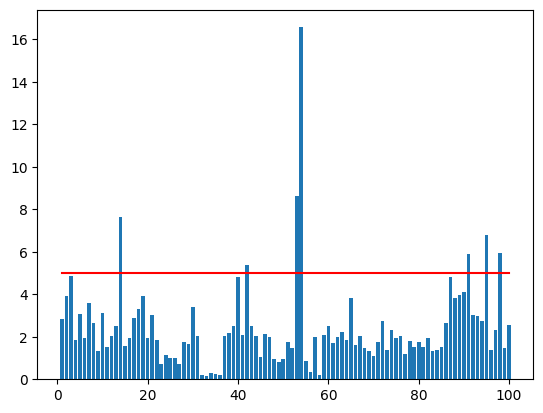

In [ ]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [5, 5], color = 'red')

In [ ]:
smape_list.describe()

count    100.000000
mean       2.457923
std        2.017567
min        0.143993
25%        1.507035
50%        2.009891
75%        2.934320
max       15.893454
dtype: float64

In [ ]:
xgb_params['best_it'] = best_it
xgb_params.to_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/xgboost/hyperparameter_xgb_solar_final.csv', index=False)

In [ ]:
## best hyperparameters 불러오기
xgb_params = pd.read_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/xgboost/hyperparameter_xgb_solar_final.csv')
xgb_params.head()

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample,best_it
0,100,0.07,5,7,0.9,1,102
1,100,0.07,5,8,0.7,1,201
2,100,0.05,1,8,0.7,1,41
3,100,0.05,1,8,0.5,1,68
4,100,0.05,5,3,0.9,1,88


## test 전처리 데이터 불러오기

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/processing/test_preprocessed_incsolar_month.csv')
test.head()

,num,date_time,prec,wind,hum,temp,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH,solar_flag
0,1,2022-08-25 00:00:00,0.0,2.2,72,23.5,3,8,34,1627.80,1706.318118,446.882767,0,0.000000,1.000000,58.3456,-0.5,0
1,1,2022-08-25 01:00:00,0.0,0.9,72,23.0,3,8,34,1550.08,1622.620235,439.662704,0,0.258819,0.965926,57.4456,-1.5,0
2,1,2022-08-25 02:00:00,0.0,1.5,75,22.7,3,8,34,1431.12,1506.971294,412.071906,0,0.500000,0.866025,57.8725,-2.8,0
3,1,2022-08-25 03:00:00,0.0,1.3,78,22.1,3,8,34,1372.20,1437.365647,391.205981,0,0.707107,0.707107,57.9376,-4.7,0
4,1,2022-08-25 04:00:00,0.0,1.0,77,21.8,3,8,34,1381.72,1447.321412,381.099697,0,0.866025,0.500000,56.9961,-6.9,0


## 예측

In [ ]:
preds = np.array([])
for i in tqdm(range(100)):

    y_train = train.loc[train.num == i+1, 'power']
    x_train, x_test = train.loc[train.num == i+1, ].iloc[:, 3:], test.loc[test.num == i+1, ].iloc[:,2:]
    x_test = x_test[x_train.columns]

    xgb = XGBRegressor(seed = 10, n_estimators = xgb_params.iloc[i, -1], eta = xgb_params.iloc[i, 1],
                        min_child_weight = xgb_params.iloc[i, 2], max_depth = int(xgb_params.iloc[i, 3]),
                        colsample_bytree=xgb_params.iloc[i, 4], subsample=xgb_params.iloc[i, 5], eval_metric = 'mae')

    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_test)
    preds = np.append(preds, y_pred)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


In [ ]:
# 예측 결과 시각화
preds = pd.Series(preds)

fig, ax = plt.subplots(100, 1, figsize=(100,200), sharex = True)
ax = ax.flatten()
for i in range(100):
    train_y = train.loc[train.num == i+1, 'power'].reset_index(drop = True)
    test_y = preds[i*168:(i+1)*168]
    ax[i].scatter(np.arange(2040) , train.loc[train.num == i+1, 'power'])
    ax[i].scatter(np.arange(2040, 2040+168) , test_y)
    ax[i].tick_params(axis='both', which='major', labelsize=6)
    ax[i].tick_params(axis='both', which='minor', labelsize=4)
#plt.savefig('./predict_xgb.png')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('/content/drive/MyDrive/전력사용량 예측 공모전/data/xgboost/submission_xgb_solar.csv', index = False)